<a href="https://colab.research.google.com/github/luanaapms/analytics-td/blob/main/ab_testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#A/B TESTING


## Configurações de Ambiente

In [ ]:
!pip install pyspark
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("ABtesting") \
    .getOrCreate()

In [ ]:
import kagglehub

path = kagglehub.dataset_download("faviovaz/marketing-ab-testing")

print("Path to dataset files:", path)

100%|██████████| 5.23M/5.23M [00:00<00:00, 116MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/faviovaz/marketing-ab-testing/versions/1


In [ ]:
# dataset
df = spark.read.csv(path + '/marketing_AB.csv', inferSchema = True, header = True)
df.show(5)

+---+-------+----------+---------+---------+------------+-------------+
|_c0|user id|test group|converted|total ads|most ads day|most ads hour|
+---+-------+----------+---------+---------+------------+-------------+
|  0|1069124|        ad|    false|      130|      Monday|           20|
|  1|1119715|        ad|    false|       93|     Tuesday|           22|
|  2|1144181|        ad|    false|       21|     Tuesday|           18|
|  3|1435133|        ad|    false|      355|     Tuesday|           10|
|  4|1015700|        ad|    false|      276|      Friday|           14|
+---+-------+----------+---------+---------+------------+-------------+
only showing top 5 rows



## Análise Exploratória

In [ ]:
from pyspark.sql import functions as F

# taxas de conversão
conversion_counts = df.filter(F.col("test group").isin(["ad", "psa"])) \
    .groupBy("test group") \
    .agg(
        F.sum(F.col("converted").cast("int")).alias("conversions"),
        F.count("*").alias("total_users")
    )

results = conversion_counts.collect()

data = {row['test group']: {'conversions': row['conversions'], 'total': row['total_users']} for row in results}

ad_success = data['ad']['conversions']
ad_total = data['ad']['total']
psa_success = data['psa']['conversions']
psa_total = data['psa']['total']

ad_rate = ad_success / ad_total
psa_rate = psa_success / psa_total

# lift abs
lift = ad_rate - psa_rate

print(f"Taxa de conversão AD: {ad_rate:.4f}")
print(f"Taxa de conversão PSA: {psa_rate:.4f}")
print(f"Lift absoluto (AD - PSA): {lift:.4f}")

Taxa de conversão AD: 0.0255
Taxa de conversão PSA: 0.0179
Lift absoluto (AD - PSA): 0.0077


In [ ]:
from statsmodels.stats.proportion import proportions_ztest
import math

se = math.sqrt(
    (ad_rate * (1 - ad_rate)) / ad_total +
    (psa_rate * (1 - psa_rate)) / psa_total
)

# IC95%
ci_lower = lift - 1.96 * se
ci_upper = lift + 1.96 * se

# Z-test
successes = [ad_success, psa_success]
totals = [ad_total, psa_total]
z_stat, p_val = proportions_ztest(successes, totals)

# lift relativo
lift_relativo = (lift / psa_rate) * 100

print(f"Intervalo de confiança 95%: [{ci_lower:.4f}, {ci_upper:.4f}]")
print(f"Lift relativo: {lift_relativo:.2f}%")
print(f"Test Z: {z_stat:.4f}")
print(f"P-value: {p_val:.4f}")

if p_val < 0.05:
    print("p < 0.05 - Rejeita H₀: diferença significativa.")
else:
    print("p ≥ 0.05 - Não rejeita H₀: sem diferença significativa.")

Intervalo de confiança 95%: [0.0060, 0.0094]
Lift relativo: 43.09%
Test Z: 7.3701
P-value: 0.0000
p < 0.05 - Rejeita H₀: diferença significativa.


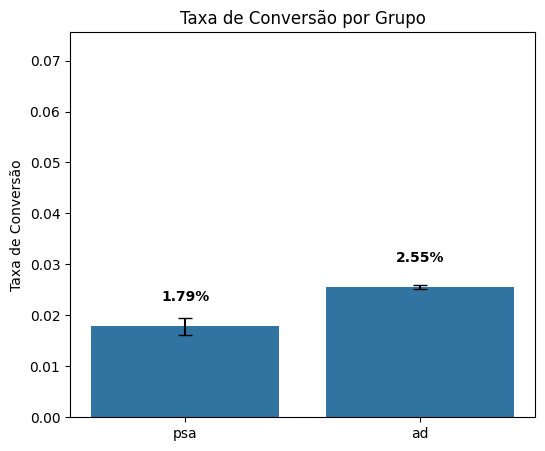

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# gerando gráfico
grupos = ['psa', 'ad']
taxas = [psa_rate, ad_rate]

se_ad = math.sqrt(ad_rate * (1 - ad_rate) / ad_total)
se_psa = math.sqrt(psa_rate * (1 - psa_rate) / psa_total)
errors = [1.96 * se_psa, 1.96 * se_ad]

plt.figure(figsize=(6,5))
ax = sns.barplot(x=grupos, y=taxas)

# barra de erro - intervalo de confiança
ax.errorbar(x=np.arange(len(grupos)), y=taxas, yerr=errors, fmt='none', c='black', capsize=5)

plt.title("Taxa de Conversão por Grupo")
plt.ylabel("Taxa de Conversão")
plt.ylim(0, max(taxas) + 0.05)


for i, v in enumerate(taxas):
    ax.text(i, v + 0.005, f"{v:.2%}", ha='center', fontweight='bold')

plt.show()

# Conclusão:
Após testes indicados de análise, se percebe que a taxa de conversão do grupo AD teve efeito significativamente melhor que a do grupo PSA.